In [2]:
import os
import requests, zipfile, io
! pip install  seaborn

  Running setup.py bdist_wheel for seaborn: started
  Running setup.py bdist_wheel for seaborn: finished with status 'done'
  Stored in directory: C:\Users\mail2\AppData\Local\pip\Cache\wheels\29\af\4b\ac6b04ec3e2da1a450e74c6a0e86ade83807b4aaf40466ecda
Successfully built seaborn


In [3]:
# load data into platform
url = requests.get('https://he-s3.s3.amazonaws.com/media/hackathon/deep-learning-challenge-1/identify-the-objects/a0409a00-8-dataset_dp.zip')
data = zipfile.ZipFile(io.BytesIO(url.content))
data.extractall()

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## load files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print ('The train data has {} images.'.format(train.shape[0]))
print ('The test data has {} images.'.format(test.shape[0]))

The train data has 3215 images.
The test data has 1732 images.


In [4]:
# unique label count
print ('The train data has {} unique labels'.format(train['label'].nunique()))

The train data has 25 unique labels


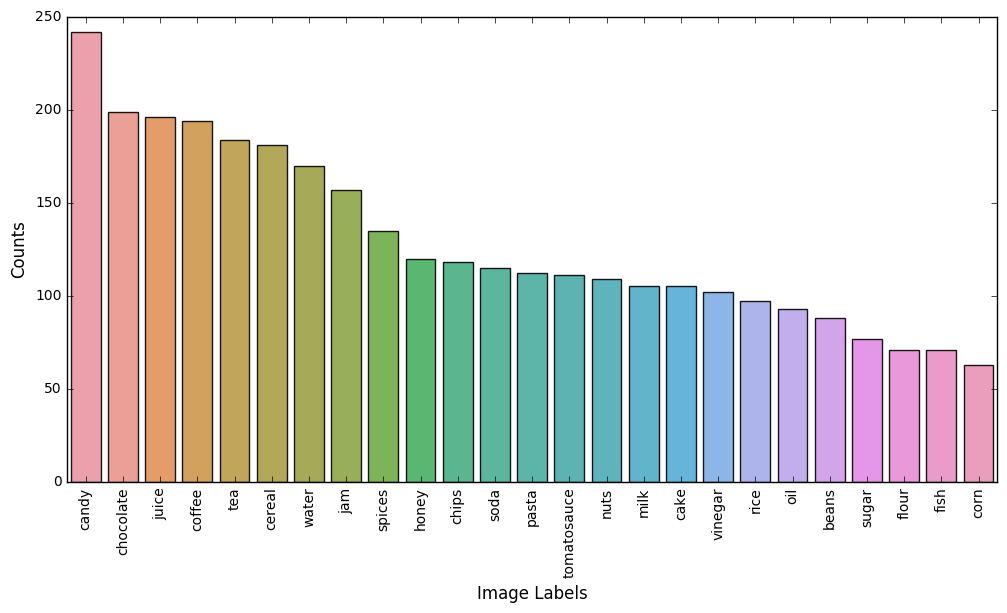

In [5]:
# lets see the distribution

label_counts = train.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [6]:
# set path to read train and test image
TRAIN_PATH = 'train_img/'
TEST_PATH = 'test_img/'

In [7]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64)) # you can resize to  (128,128) or (256,256)
    return img

In [8]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|█████████████████████████████████████████████████████████████████████████████| 1732/1732 [00:04<00:00, 351.63it/s]


In [9]:
# normalize the images
x_train = np.array(train_data, np.float32) / 255.
x_test = np.array(test_data, np.float32) / 255.

In [10]:
# target variable - encoding numeric value
label_list = train['label'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]

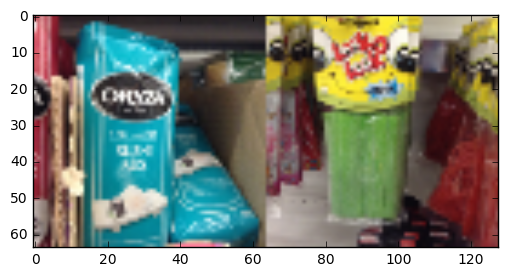

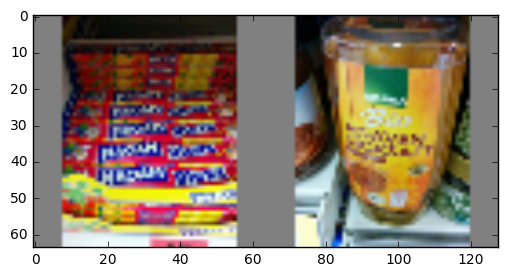

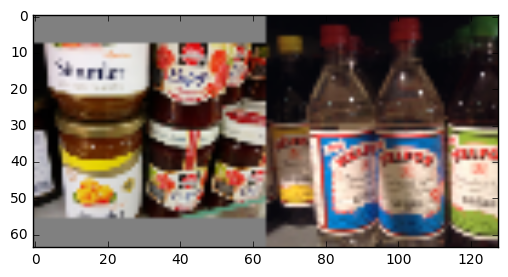

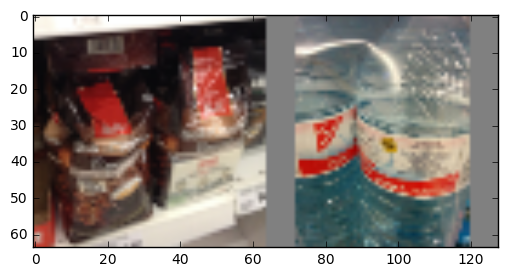

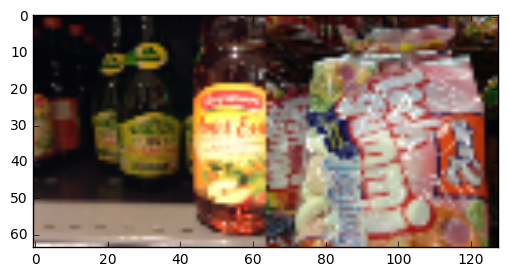

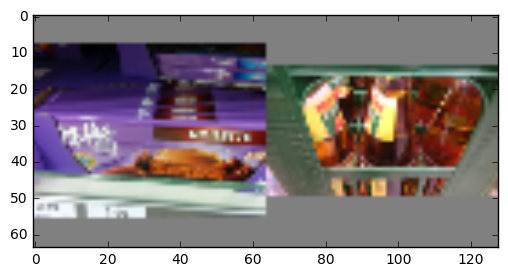

In [11]:
# check some images
def show_images(ix):
    image_train = read_image(TRAIN_PATH + train.image_id[ix] + '.png')
    image_test = read_image(TEST_PATH + test.image_id[ix] + '.png')
    
    pair = np.concatenate((image_train, image_test), axis=1)
    
    plt.figure(figsize = (6,6))
    plt.imshow(pair)
    
# first 6images in train and test set
for idx in range(6):
    show_images(idx)

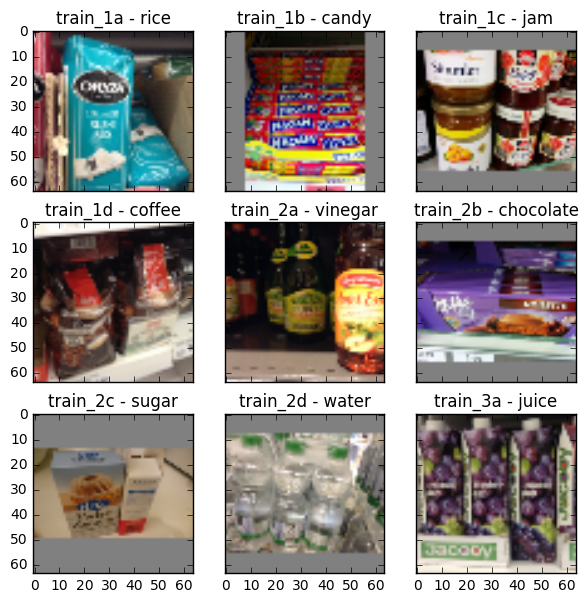

In [12]:
## just images doesn't help, lets see the images with their respective labels
plt.rc('axes', grid=False)

_, axs = plt.subplots(3,3, sharex = 'col', sharey='row', figsize = (7,7))
axs = axs.ravel()

# lets see first 8 images - you can increase i value to see more images
for i, (image_name, label) in enumerate(zip(train.image_id, train.label)):
    if i <= 8:
        img = read_image(TRAIN_PATH + image_name + '.png')
        axs[i].imshow(img)
        axs[i].set_title('{} - {}'.format(image_name, label))
    else:
        break


In [13]:
# lets train our first model, we'll use keras.

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


In [14]:
## keras accepts target variable as a ndarray so that we can set one output neuron per class
y_train = to_categorical(y_train)

In [15]:
## neural net architechture

model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (64,64,3))) # if you resize the image above, shape would be (128,128,3)
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [16]:
early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [ ]:
model.fit(x_train, y_train, batch_size=100, epochs=100, validation_split=0.3)

Train on 2250 samples, validate on 965 samples
Epoch 1/100
1900/2250 [========================>.....] - ETA: 11s - loss: 3.1567 - acc: 0.0716

In [19]:
# make prediction
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis= 1)

In [20]:
# get predicted labels
y_maps = dict()
y_maps = {v:k for k, v in Y_train.items()}
pred_labels = [y_maps[k] for k in predictions]

In [21]:
# make submission
sub1 = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
sub1.to_csv('sub_one.csv', index=False)

I see this product is candy


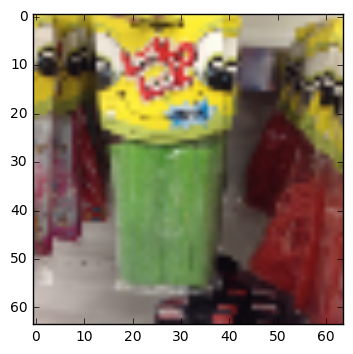

I see this product is candy


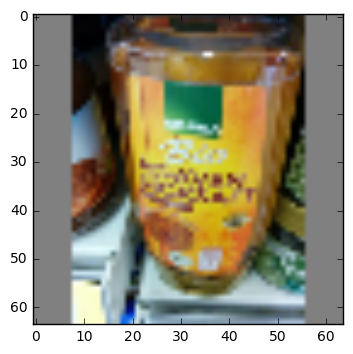

I see this product is candy


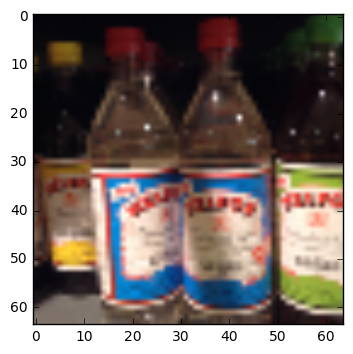

I see this product is candy


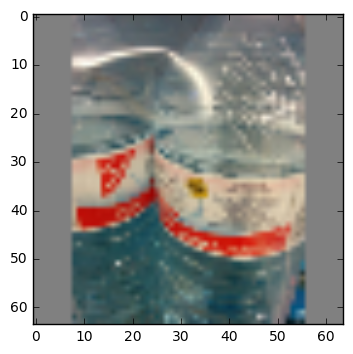

I see this product is candy


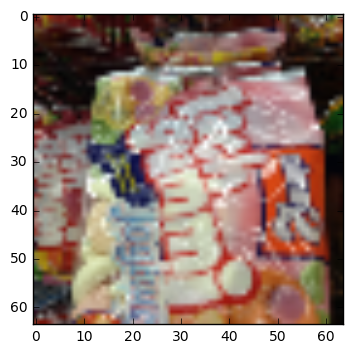

In [22]:
## lets see what our classifier predicts on test images

# top 5 predictions
for i in range(5):
    print('I see this product is {}'.format(pred_labels[i]))
    plt.imshow(read_image(TEST_PATH +'{}.png'.format(test.image_id[i])))
    plt.show()